In [572]:
import pandas as pd
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
warnings.simplefilter("ignore")
from scipy.signal import find_peaks
from scipy import stats

In [573]:
# Import data
data = pd.read_csv("data/data_Q1.csv")
df_wars = pd.DataFrame(data)
df_movies = pd.read_csv("data/filtered_movie_data.csv")

In [574]:
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
exploded_genres = df_movies.explode('Genres')
# Step 2: Get unique genres
unique_genres = exploded_genres['Genres'].unique()
# Step 3: Print the list of unique genres
#print(unique_genres)

# List of words/parts to search for in genres
search_terms = ["war", "spy", "patriot", "propagand", "hero", "social", "politic", "apocalyp", "topia"]

# Create a regex pattern to match any of the search terms
pattern = '|'.join(search_terms)  # Join terms with 'or' for regex

# Step 4: Filter genres that contain any of the specified words
matching_genres = [genre for genre in unique_genres if isinstance(genre, str) and pd.Series(genre).str.contains(pattern, case=False, na=False).any()]

# Step 5: Print the matching genres
print(matching_genres)


['War film', 'Political drama', 'Superhero movie', 'Spy', 'Political cinema', 'Dystopia', 'Political satire', 'Propaganda film', 'Social issues', 'Social problem film', 'Gulf War', 'Political thriller', 'Superhero', 'Apocalyptic and postapocalyptic fiction', 'Antiwar', 'Antiwar film', 'Glamorized Spy Film', 'Nuclear warfare', 'Cold War', 'War effort', 'Patriotic film', 'Political Documetary', 'The Netherlands in World War II']


In [575]:
def clean_genres(df_movies, genre_1, genre_2):
    # Convert the 'Genres' column from string to list (if it's in string format)
    df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Step 2: Replace 'Superhero movie' with 'Superhero' and remove duplicates in each genre list
    df_movies['Genres'] = df_movies['Genres'].apply(lambda genres: list(set([genre if genre != genre_2 else genre_1 for genre in genres])))

    return df_movies

# Example of how to use it with your DataFrame:
df_movies = clean_genres(df_movies, "Superhero", "Superhero movie")
df_movies = clean_genres(df_movies, "Antiwar", "Antiwar film")
df_movies = clean_genres(df_movies, "Social issues", "Social problem film")
df_movies = clean_genres(df_movies, "Spy", "Glamorized Spy Film")

In [576]:
def analyze_genre_wars(df_movies, df_wars, genre_name):
    """
    Analyze the top 10 peak years for a given genre and find the relevant wars
    that occurred during ±2 years of those peak years.

    Parameters:
    - df_movies: DataFrame containing movie data with 'Year' and 'Genre'.
    - df_wars: DataFrame containing war data with 'StartYear', 'EndYear', and 'WarName'.
    - genre_name: The genre of films to analyze (e.g., "War film").
    """
    # Step 1: Count the number of films for the given genre
    genre_films = count_genre_over_years(df_movies, genre_name)

    # Step 2: Get the proportion of films for each year
    genre_films_proportion = count_genre_proportion(df_movies, genre_name)

    # Step 3: Plot the proportion of films for the genre over the years
    #sns.lineplot(data=genre_films_proportion, x="Year", y="Proportion")
    #name_plot(f"Proportion of {genre_name} Films Released", f"Proportion of {genre_name} Films Over the Years")

    # Step 6: Find the peaks in the proportion of films
    peak_indices, _ = find_peaks(genre_films_proportion["Proportion"])

    # Extract the peak years and corresponding values
    peak_years = genre_films_proportion.iloc[peak_indices]["Year"]
    peak_values = genre_films_proportion.iloc[peak_indices]["Proportion"]

    # Create a DataFrame of peaks
    peaks_df = pd.DataFrame({
        'Year': peak_years,
        'Proportion': peak_values
    })

    # Sort the peaks by Proportion in descending order and select the top 10
    top_peaks = peaks_df.sort_values(by="Proportion", ascending=False).head(10)

    # Extract top 10 peak years
    top_peak_years = top_peaks['Year'].values

    # Now, top_peak_years contains the top 10 peak years

    # Step 7: Define the time intervals for ±2 years around the peak years
    time_intervals = []
    for year in top_peak_years:
        start_year = year - 2
        end_year = year + 2
        time_intervals.append((start_year, end_year))

    # Step 8: Find the wars that happened during those time intervals
    wars_in_intervals = []
    unique_wars = set()  # Use a set to store unique war names

    for start_year, end_year in time_intervals:
        # Filter wars that started before or ended after the time interval
        relevant_wars = df_wars[
            (((start_year <= df_wars['StartYear']) & (df_wars['StartYear'] <= end_year)) |
             ((start_year <= df_wars['EndYear']) & (df_wars['EndYear'] <= end_year)) |
             ((df_wars['StartYear'] < start_year) & (df_wars["EndYear"] > end_year)))
        ]

        for _, war in relevant_wars.iterrows():
            if war['WarName'] not in unique_wars:
                unique_wars.add(war['WarName'])
                
                # Find the closest peak year that fits in the ±2 interval
                peak_year_for_war = None
                for peak_year in top_peak_years:
                    if peak_year - 2 <= war['StartYear'] <= peak_year + 2 or peak_year - 2 <= war['EndYear'] <= peak_year + 2 or\
                    ((war['StartYear'] < peak_year - 2) & (war['EndYear'] > peak_year + 2)):
                        peak_year_for_war = peak_year
                        break

                # Append the war details with the corresponding peak year
                wars_in_intervals.append((war['StartYear'], war['EndYear'], war['WarName'], peak_year_for_war))

    # Step 10: Create a DataFrame to store the result and include peak year
    wars_in_intervals_df = pd.DataFrame(wars_in_intervals, columns=["Start Year", "End Year", "War Name", "Peak Year"])

    # Step 11: Print the final DataFrame
    return genre_films_proportion['Year'], genre_films_proportion['Proportion'],wars_in_intervals_df

In [577]:
print(count_genre_over_years(df_movies, "Patriotic film"))
print(count_genre_over_years(df_movies, "Nuclear warfare"))
print(count_genre_over_years(df_movies, "War effort"))
print(count_genre_over_years(df_movies, "Political Documetary"))

   Year  Count
0  1944      2
   Year  Count
0  1959      1
1  1984      1
   Year  Count
0  1943      1
   Year  Count
0  2004      1


In [578]:
inspected_genres = ["War film", "Spy", "Superhero", "Antiwar", "Social issues", "Political satire", "Political thriller", "Political cinema", "Political drama", "Dystopia", "Apocalyptic and postapocalyptic fiction"]
military_genres = ["War film", "Spy", "Superhero"]
military_and_antiwar = ["War film", "Spy", "Superhero", "Antiwar"]
reflecting_genres = ["Political satire", "Political thriller", "Political cinema", "Political drama"]
dystopian_genres = ["Dystopia", "Apocalyptic and postapocalyptic fiction"]

                   War Name  Mean Peak Year
0       Third Sino-Japanese            1943
1             First Kashmir            1945
2               Franco-Thai            1943
3             Russo-Finnish            1940
4                     Chaco            1930
5   Second Laotian, Phase 2            1966
6            Second Kashmir            1964
7                  Cold War            1958
8      Vietnam War, Phase 2            1964
9                  Nomonhan            1940
10                Iran-Iraq            1979
11             World War II            1943
12             Arab-Israeli            1947
13              Changkufeng            1940


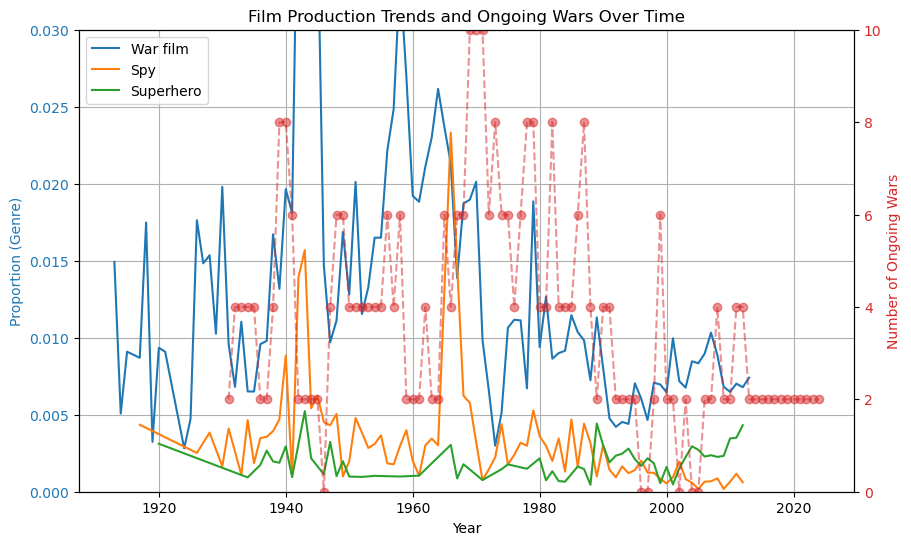

                  War Name  Mean Peak Year
0  Second Laotian, Phase 2            1966
1           Second Kashmir            1963
2                 Cold War            1958
3     Vietnam War, Phase 2            1964
4                Iran-Iraq            1979


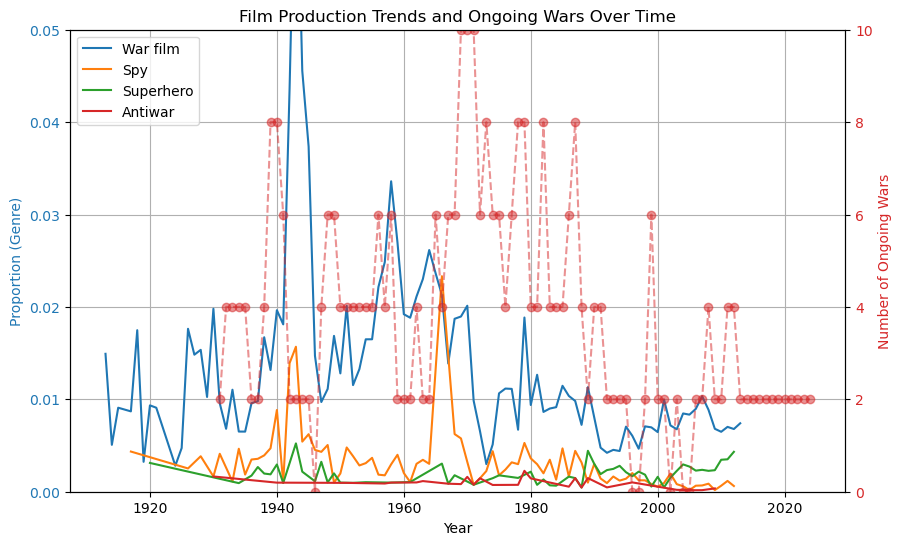

                    War Name  Mean Peak Year
0             Yom Kippur War            1971
1             Azeri-Armenian            1992
2        Communist Coalition            1968
3      Bangladesh Liberation            1971
4   Sino-Vietnamese Punitive            1979
5               Badme Border            1997
6    Second Laotian, Phase 2            1968
7                   Cold War            1968
8       Vietnam War, Phase 2            1968
9                  Iran-Iraq            1979
10          War over Lebanon            1980
11      Vietnamese-Cambodian            1976
12             Turco-Cypriot            1972
13          Falkland Islands            1980
14        Ugandian-Tanzanian            1976


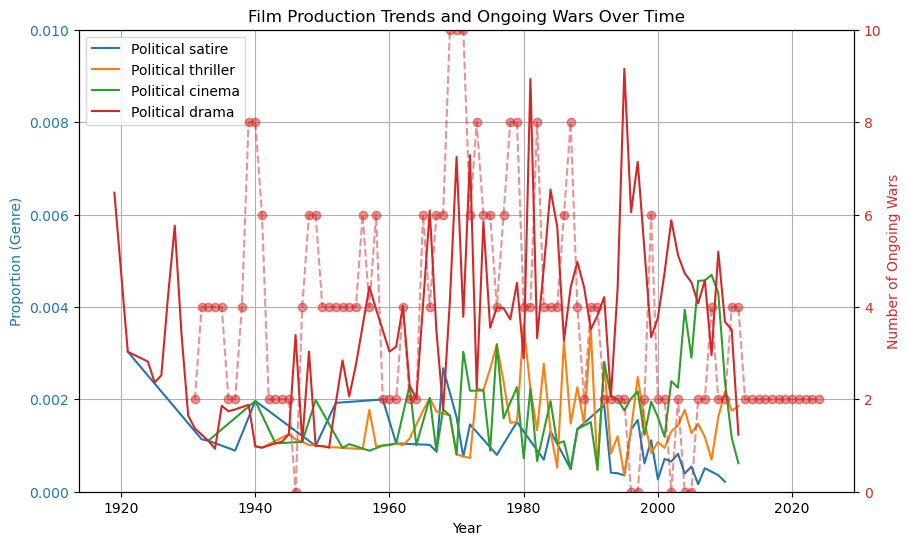

                   War Name  Mean Peak Year
0            Yom Kippur War            1973
1            Azeri-Armenian            1993
2     Bangladesh Liberation            1971
3       Communist Coalition            1971
4      Gaza-Israel conflict            2005
5                     Assam            1960
6   Second Laotian, Phase 2            1973
7                  Cold War            1973
8      Vietnam War, Phase 2            1973
9                 Iran-Iraq            1985
10            Turco-Cypriot            1973
11            Cenepa Valley            1993
12          War over Angola            1973


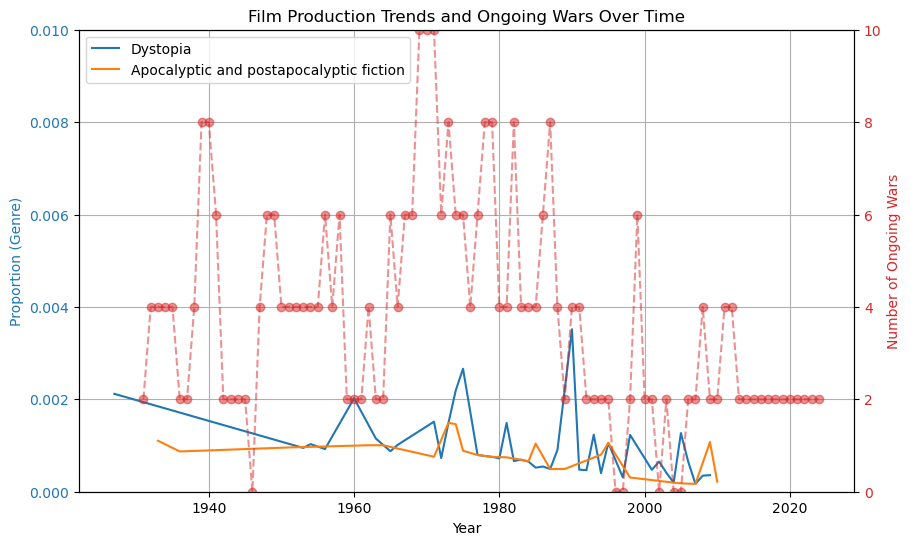

In [579]:
'''
def count_ongoing_wars(df_wars):
    # Get the range of years from the StartYear to the EndYear
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the count of ongoing wars for each year
    ongoing_wars_count = []
    
    # Iterate over each year in the range
    for year in years:
        # Count the number of wars that are ongoing in this year
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    # Create a DataFrame with the year and the corresponding count of ongoing wars
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

ongoing_wars = count_ongoing_wars(df_wars)
data = ongoing_wars['Ongoing Wars'].values.reshape(1, -1)

# Plot the heatmap
plt.figure(figsize=(10, 6))  # Create a wide figure for better readability
plt.plot(ongoing_wars['Year'], ongoing_wars['Ongoing Wars'], marker='o', color='b', label='Ongoing Wars')

# Set labels and title
plt.title('Heatmap of Ongoing Wars Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ongoing Wars')
plt.xlim(1910, 2015)

def inspect_peaks_events(genre_list, ylim):
    plt.figure(figsize=(10, 6))
    peak_wars = []
    # Loop through genres and plot them on the same plot
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the same axes
        plt.plot(genre_data[0], genre_data[1],label=f"{genre}")

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])
    plt.title('Film Production Trends for Different Genres')
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.ylim(0, ylim)
    plt.legend()
    plt.grid(True)
    
    intersection = set(peak_wars[0]['War Name'])  # Start with the "War Name" from the first genre
    
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []

    # Iterate through the filtered data frames and compute the mean for each "War Name"
    for war_name in intersection:
        # Collect Peak Year values for the intersecting War Name from each genre
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        
        # Compute the mean for the Peak Year values for this War Name
        mean_peak_year = min(peak_years)
        
        # Store the results (War Name and Mean Peak Year)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    # Convert the mean values to a DataFrame
    mean_df = pd.DataFrame(mean_values)

    for _, row in mean_df.iterrows():
        plt.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")
# Print the DataFrame with the mean values for inspection
    print(mean_df)

    # Display the plot with the heatmap and vertical lines
    plt.show()
'''
def count_ongoing_wars(df_wars):
    # Get the range of years from the StartYear to the EndYear
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the count of ongoing wars for each year
    ongoing_wars_count = []
    
    # Iterate over each year in the range
    for year in years:
        # Count the number of wars that are ongoing in this year
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    # Create a DataFrame with the year and the corresponding count of ongoing wars
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

def inspect_peaks_events(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])

    ax1.set_title('Film Production Trends and Ongoing Wars Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Calculate the intersection of "War Name" across all genres
    intersection = set(peak_wars[0]['War Name'])  # Start with the "War Name" from the first genre
    
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []

    # Iterate through the filtered data frames and compute the mean for each "War Name"
    for war_name in intersection:
        # Collect Peak Year values for the intersecting War Name from each genre
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        
        # Compute the mean for the Peak Year values for this War Name
        mean_peak_year = min(peak_years)
        
        # Store the results (War Name and Mean Peak Year)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    # Convert the mean values to a DataFrame
    mean_df = pd.DataFrame(mean_values)

    # Add vertical lines for each mean peak year
    #for _, row in mean_df.iterrows():
        #ax1.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")

    # Print the DataFrame with the mean values for inspection
    print(mean_df)

    # Create the secondary y-axis for ongoing wars
    ax2 = ax1.twinx()

    # Calculate ongoing wars per year
    ongoing_wars_df = count_ongoing_wars(df_wars)

    # Plot the number of ongoing wars on the secondary y-axis
    ax2.plot(ongoing_wars_df['Year'], ongoing_wars_df['Ongoing Wars'], color='tab:red', label='Ongoing Wars', linestyle='--', marker='o', alpha = 0.5)

    ax2.set_ylabel('Number of Ongoing Wars', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10)

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    #ax2.legend(loc='upper right')

    # Display the plot
    plt.show()
inspect_peaks_events(military_genres, 0.03)
inspect_peaks_events(military_and_antiwar, 0.05)
inspect_peaks_events(reflecting_genres, 0.01)
inspect_peaks_events(dystopian_genres, 0.01)


                   War Name  Mean Peak Year
0       Third Sino-Japanese            1943
1             First Kashmir            1945
2               Franco-Thai            1943
3             Russo-Finnish            1940
4                     Chaco            1930
5   Second Laotian, Phase 2            1966
6            Second Kashmir            1964
7                  Cold War            1958
8      Vietnam War, Phase 2            1964
9                  Nomonhan            1940
10                Iran-Iraq            1979
11             World War II            1943
12             Arab-Israeli            1947
13              Changkufeng            1940
Correlation between Ongoing Wars and War Film Peaks: -0.005102622299621573


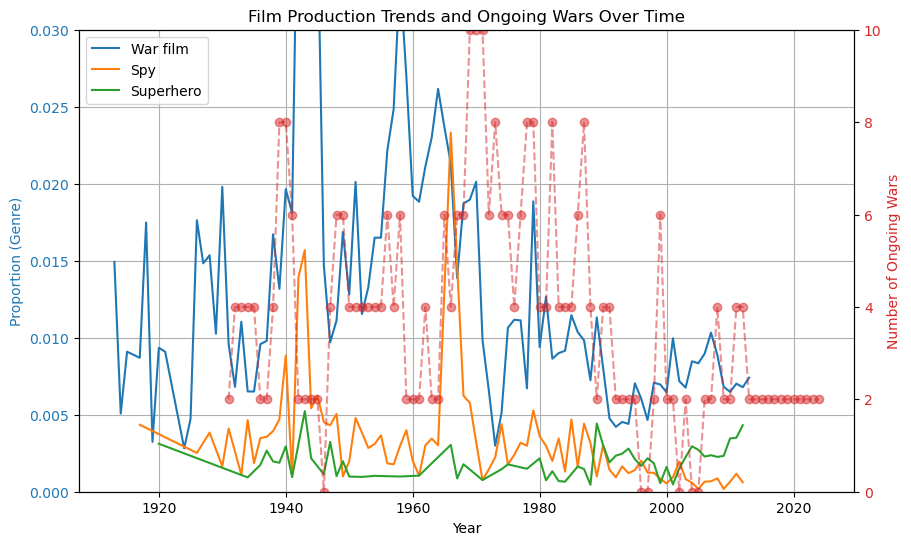

                  War Name  Mean Peak Year
0  Second Laotian, Phase 2            1966
1           Second Kashmir            1963
2                 Cold War            1958
3     Vietnam War, Phase 2            1964
4                Iran-Iraq            1979
Correlation between Ongoing Wars and War Film Peaks: 0.5623488691175613


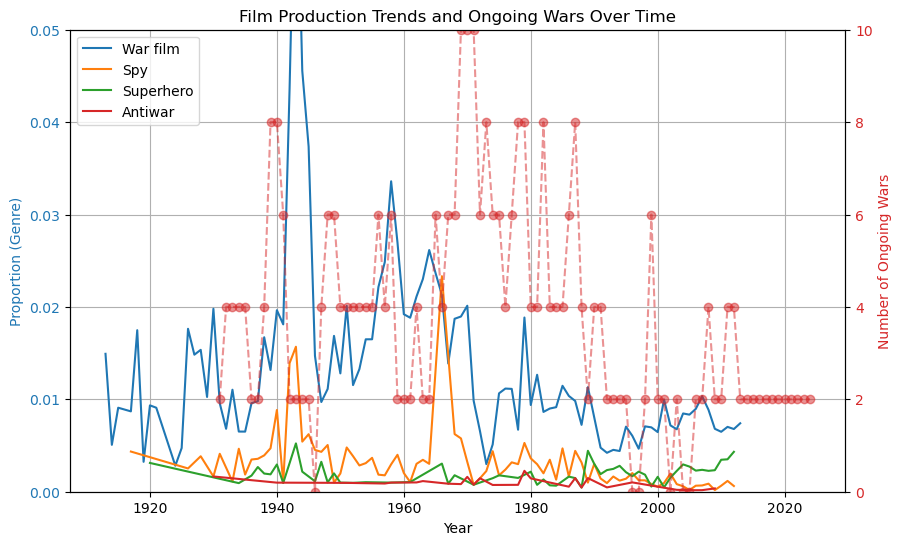

                    War Name  Mean Peak Year
0             Yom Kippur War            1971
1             Azeri-Armenian            1992
2        Communist Coalition            1968
3      Bangladesh Liberation            1971
4   Sino-Vietnamese Punitive            1979
5               Badme Border            1997
6    Second Laotian, Phase 2            1968
7                   Cold War            1968
8       Vietnam War, Phase 2            1968
9                  Iran-Iraq            1979
10          War over Lebanon            1980
11      Vietnamese-Cambodian            1976
12             Turco-Cypriot            1972
13          Falkland Islands            1980
14        Ugandian-Tanzanian            1976
Correlation between Ongoing Wars and War Film Peaks: -0.6910444595413126


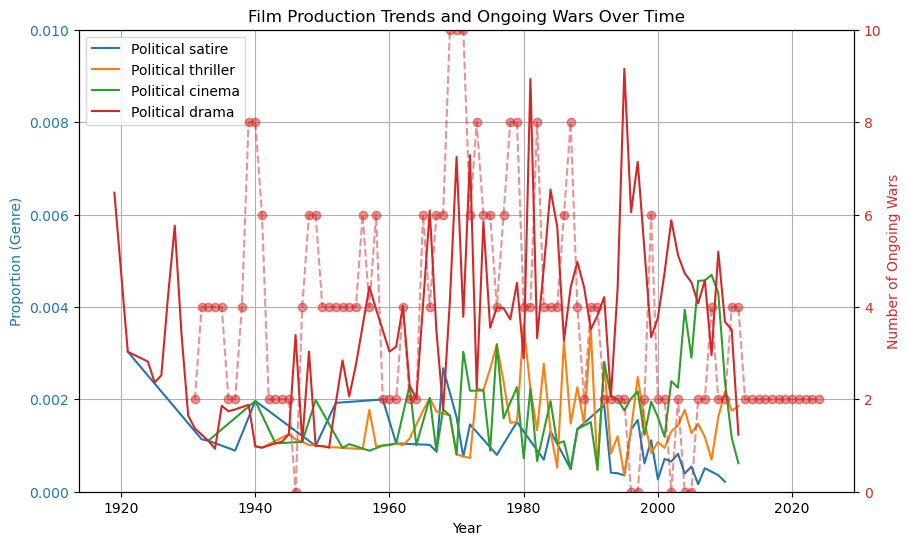

                   War Name  Mean Peak Year
0            Yom Kippur War            1973
1            Azeri-Armenian            1993
2     Bangladesh Liberation            1971
3       Communist Coalition            1971
4      Gaza-Israel conflict            2005
5                     Assam            1960
6   Second Laotian, Phase 2            1973
7                  Cold War            1973
8      Vietnam War, Phase 2            1973
9                 Iran-Iraq            1985
10            Turco-Cypriot            1973
11            Cenepa Valley            1993
12          War over Angola            1973
Correlation between Ongoing Wars and War Film Peaks: -0.6678801573344454


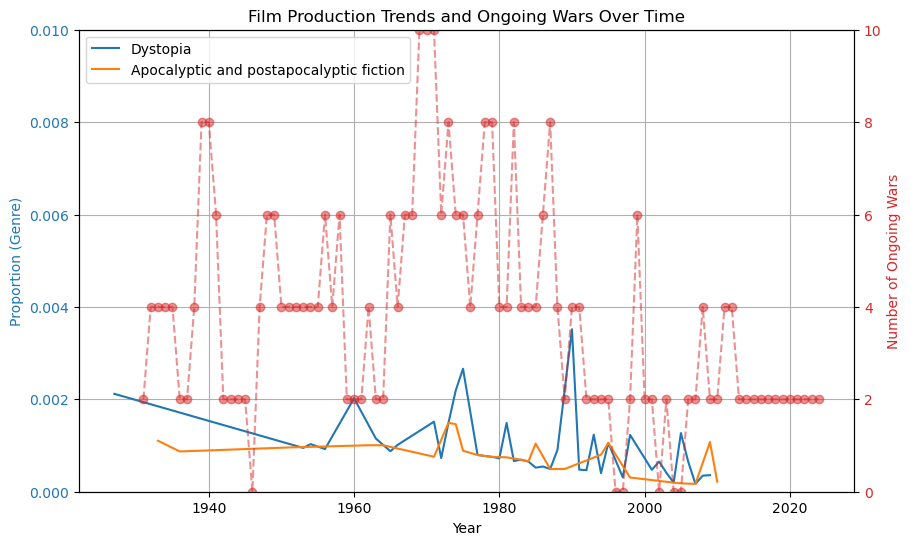

In [580]:
def count_ongoing_wars(df_wars):
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    ongoing_wars_count = []
    
    for year in years:
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

# Function to calculate the correlation and inspect peaks events
def inspect_peaks_events(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")
        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])
    
    ax1.set_title('Film Production Trends and Ongoing Wars Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Calculate the intersection of "War Name" across all genres
    intersection = set(peak_wars[0]['War Name'])
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []
    for war_name in intersection:
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        mean_peak_year = min(peak_years)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    mean_df = pd.DataFrame(mean_values)
    
    #for _, row in mean_df.iterrows():
        #ax1.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")

    print(mean_df)

    # Create the secondary y-axis for ongoing wars
    ax2 = ax1.twinx()
    ongoing_wars_df = count_ongoing_wars(df_wars)
    ax2.plot(ongoing_wars_df['Year'], ongoing_wars_df['Ongoing Wars'], color='tab:red', linestyle='--', marker='o', alpha=0.5)
    ax2.set_ylabel('Number of Ongoing Wars', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10)

    # Calculate the correlation between Ongoing Wars and War Film Trends
    merged_df = pd.merge(ongoing_wars_df, mean_df, left_on='Year', right_on='Mean Peak Year', how='inner')
    correlation = merged_df['Ongoing Wars'].corr(merged_df['Mean Peak Year'])
    print(f"Correlation between Ongoing Wars and War Film Peaks: {correlation}")

    ax1.legend(loc='upper left')
    plt.show()

# Example usage (assuming df_wars and df_movies are available):
inspect_peaks_events(military_genres, 0.03)
inspect_peaks_events(military_and_antiwar, 0.05)
inspect_peaks_events(reflecting_genres, 0.01)
inspect_peaks_events(dystopian_genres, 0.01)

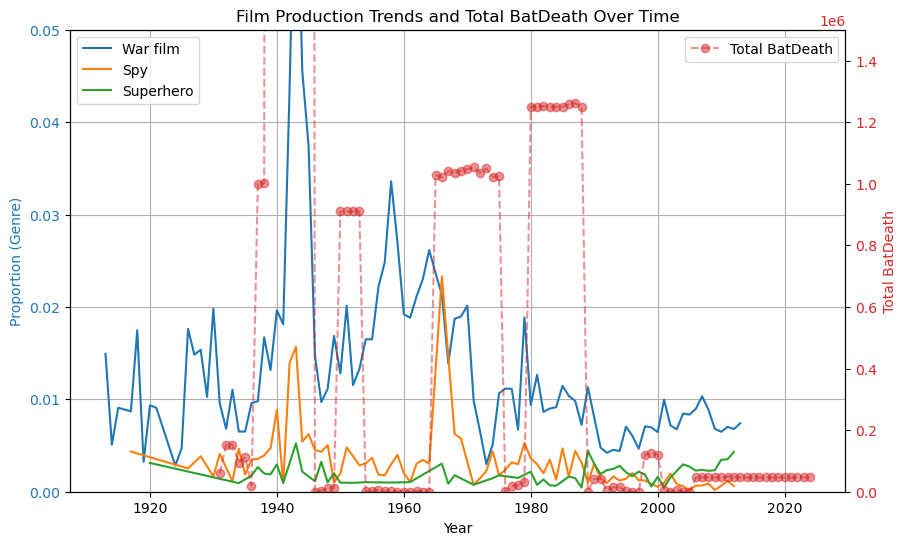

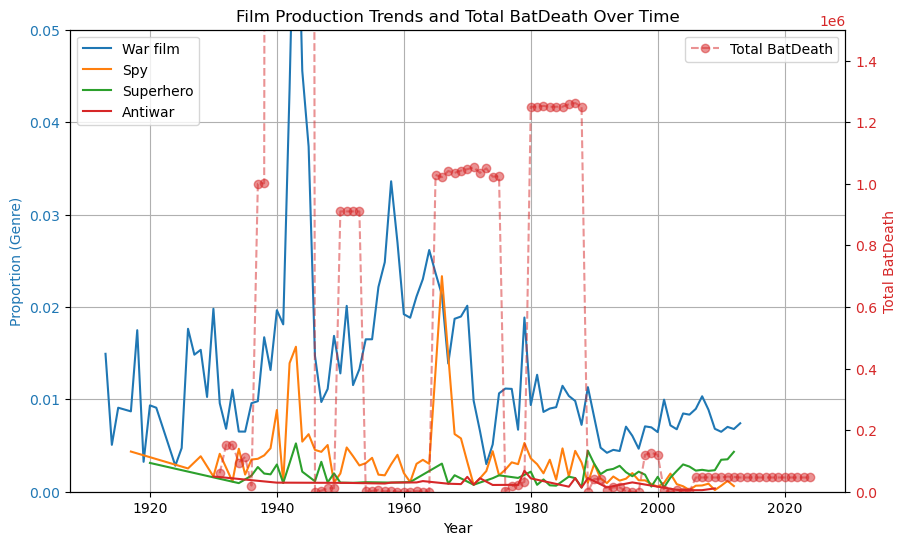

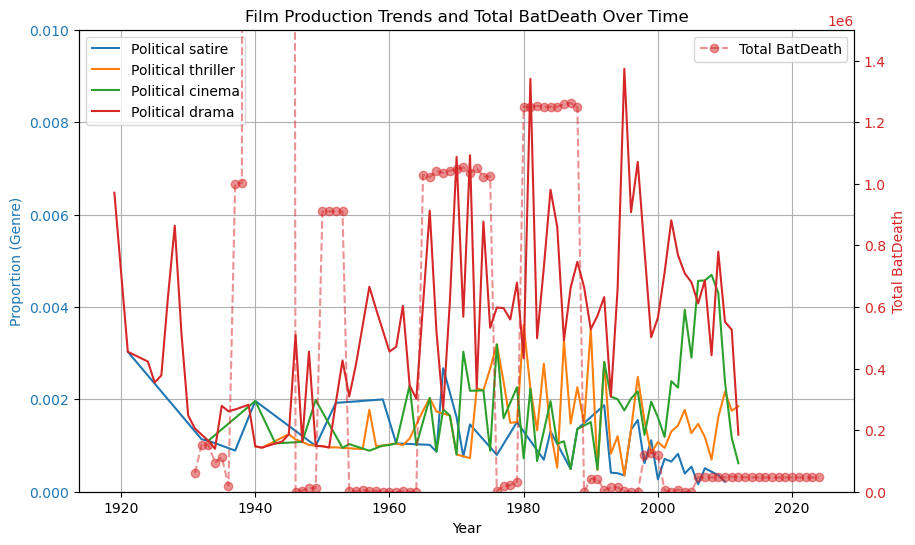

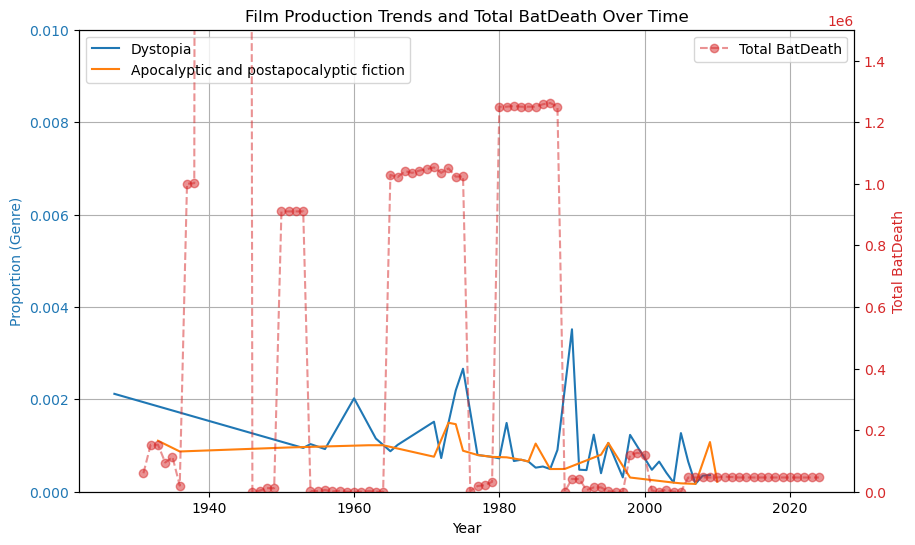

In [581]:
def calculate_total_batdeath_per_year():
    # Create a series of years from the minimum start year to the maximum end year
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    
    # Initialize a list to store the summed BatDeath for each year
    total_batdeath_per_year = []
    
    # Iterate over each year in the range
    for year in years:
        total_batdeath = 0
        
        # Iterate over each war and check if it is ongoing during this year
        for _, row in df_wars.iterrows():
            start_year = row['StartYear']
            end_year = row['EndYear']
            batdeath = row['BatDeath']  # Use the BatDeath column from df_wars
            
            # Check if the war is ongoing during this year
            if start_year <= year <= end_year:
                total_batdeath += batdeath  # Add BatDeath for the ongoing war
        
        # Append the total BatDeath for this year
        total_batdeath_per_year.append(total_batdeath)
    
    # Create a DataFrame to hold the total BatDeath for each year
    total_batdeath_df = pd.DataFrame({'Year': years, 'Total BatDeath': total_batdeath_per_year})
    
    return total_batdeath_df

# Function to plot the genres and BatDeath data
def inspect_peaks_events_with_batdeath(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

    ax1.set_title('Film Production Trends and Total BatDeath Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Create the secondary y-axis for summed BatDeath
    ax2 = ax1.twinx()

    # Calculate the total BatDeath per year
    total_batdeath_df = calculate_total_batdeath_per_year()

    # Plot the summed BatDeath on the secondary y-axis
    ax2.plot(total_batdeath_df['Year'], total_batdeath_df['Total BatDeath'], color='tab:red', label='Total BatDeath', linestyle='--', marker='o', alpha=0.5)

    # Set the secondary y-axis label
    ax2.set_ylabel('Total BatDeath', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set the limits for the secondary y-axis to start from 0
    ax2.set_ylim(0, 1.5*(10**6))  # Adding a small margin to the top

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Display the plot
    plt.show()

inspect_peaks_events_with_batdeath(military_genres, 0.05)
inspect_peaks_events_with_batdeath(military_and_antiwar, 0.05)
inspect_peaks_events_with_batdeath(reflecting_genres, 0.01)
inspect_peaks_events_with_batdeath(dystopian_genres, 0.01)


In [582]:
# def calc_bat_deaths():
#     df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
#     df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

#     # 2. Expand the dataframe to have a row per year
#     expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()

#     # 3. Add a 'Year' column for each row
#     expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']

#     # 4. Distribute BatDeath evenly across the war's years
#     expanded_df['Yearly_BatDeath'] = expanded_df['BatDeath'] / expanded_df['Duration']

#     # 5. Group by year and sum the yearly deaths
#     yearly_deaths = expanded_df.groupby('Year')['Yearly_BatDeath'].sum().reset_index()

#     # 6. Ensure all years from the earliest StartYear to the latest EndYear are included
#     min_year = df_aggregated['StartYear'].min()
#     max_year = df_aggregated['EndYear'].max()
#     all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

#     # 7. Merge with the yearly_deaths dataframe and fill missing values with 0
#     final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
#     return final_df

# # Function to calculate the correlation between Total BatDeath and War Films
# def calculate_correlation_with_batdeath(df_wars, df_movies, genre_list):
#     # Initialize an empty list to accumulate War Film data for all genres
#     all_war_films_data = []
    
#     # Aggregate War Films data across all genres
#     for genre in genre_list:
#         war_films_df = count_genre_over_years(df_movies, genre)
#         all_war_films_data.append(war_films_df)
    
#     # Merge all genre data into one DataFrame
#     merged_war_films_df = pd.concat(all_war_films_data, ignore_index=True)
#     merged_war_films_df = merged_war_films_df.groupby('Year').sum().reset_index()  # Sum the counts by year

#     # Get the total BatDeath per year
#     total_batdeath_df = calc_bat_deaths(df_wars)

#     # Merge BatDeath and War Films data on 'Year'
#     merged_df = pd.merge(total_batdeath_df, merged_war_films_df, on='Year', how='inner')

#     # Calculate Pearson correlation between BatDeath and War Films
#     correlation = merged_df['Total BatDeath'].corr(merged_df['Count'])
    
#     return correlation, merged_df

# # Function to plot the data with log scaling and show the correlation
# def plot_with_batdeath_correlation(df_wars, df_movies, genre_list):
#     correlation, merged_df = calculate_correlation_with_batdeath(df_wars, df_movies, genre_list)

#     print(f"Correlation between Total BatDeath and War Films: {correlation}")
    
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     # Plot Total BatDeath on the primary axis
#     ax1.plot(merged_df['Year'], merged_df['Total BatDeath'], label='Total BatDeath', color='tab:red', linestyle='--')
#     ax1.set_xlabel('Year')
#     ax1.set_ylabel('Total BatDeath', color='tab:red')
#     ax1.tick_params(axis='y', labelcolor='tab:red')
    
#     # Apply log scaling to the Total BatDeath axis
#     #ax1.set_yscale('log')

#     # Create secondary y-axis for War Films
#     ax2 = ax1.twinx()
#     ax2.plot(merged_df['Year'], merged_df['Count'], label='War Films', color='tab:blue', linestyle='-', marker='o')
#     ax2.set_ylabel('War Films', color='tab:blue')
#     ax2.tick_params(axis='y', labelcolor='tab:blue')

#     # Apply log scaling to the War Films axis
#     #ax2.set_yscale('log')

#     ax1.grid(True)
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
    
#     plt.title('Correlation between Total BatDeath and War Films')
#     plt.show()

# # Example usage (assuming df_wars and df_movies are available):
# genre_lists = [
#     military_genres,
#     military_and_antiwar,
#     reflecting_genres,
#     dystopian_genres
# ]

# # Run the analysis for each genre list
# for genre_list in genre_lists:
#     plot_with_batdeath_correlation(df_wars, df_movies, genre_list)

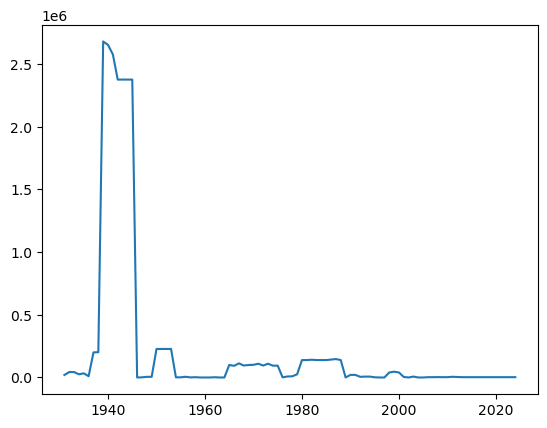

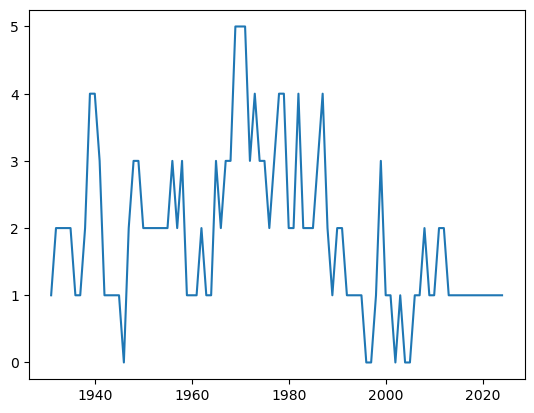

    Year  Yearly_BatDeath
0   1931     20000.000000
1   1932     43165.250000
2   1933     43165.250000
3   1934     25265.250000
4   1935     33165.250000
..   ...              ...
77  2008      2936.578947
78  2009      2431.578947
79  2010      2431.578947
80  2011      5431.578947
81  2012      3911.578947

[82 rows x 2 columns]
    Year  Count
15  1931      7
16  1932      6
17  1933     10
18  1934      7
19  1935      7
..   ...    ...
92  2008     51
93  2009     38
94  2010     30
95  2011     24
96  2012     11

[82 rows x 2 columns]
    Year  Count
4   1931      3
5   1933      1
6   1934      5
7   1935      2
8   1936      4
..   ...    ...
80  2008      5
81  2009      1
82  2010      3
83  2011      4
84  2012      1

[81 rows x 2 columns]
    Year  Count_x  Count_y  Count
0   1931        7        3     10
1   1933       10        1     11
2   1934        7        5     12
3   1935        7        2      9
4   1936       11        4     15
..   ...      ...      ...    .

In [583]:
def calc_bat_deaths():
    df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

    # 2. Expand the dataframe to have a row per year
    expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()

    # 3. Add a 'Year' column for each row
    expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']

    # 4. Distribute BatDeath evenly across the war's years
    expanded_df['Yearly_BatDeath'] = expanded_df['BatDeath'] / expanded_df['Duration']

    # 5. Group by year and sum the yearly deaths
    yearly_deaths = expanded_df.groupby('Year')['Yearly_BatDeath'].sum().reset_index()

    # 6. Ensure all years from the earliest StartYear to the latest EndYear are included
    min_year = df_aggregated['StartYear'].min()
    max_year = df_aggregated['EndYear'].max()
    all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

    # 7. Merge with the yearly_deaths dataframe and fill missing values with 0
    final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
    return final_df
def wars_per_year():
    df_agg = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    min_year = df_agg['StartYear'].min()
    max_year = df_agg['EndYear'].max()

    # 2. Create a list of all years in the range
    all_years = range(min_year, max_year + 1)

    # 3. For each year, count how many wars were ongoing
    ongoing_counts = []
    for year in all_years:
        # Count how many wars have StartYear <= year <= EndYear
        count = ((df_agg['StartYear'] <= year) & (df_agg['EndYear'] >= year)).sum()
        ongoing_counts.append(count)

    # 4. Create a dataframe of results
    ongoing_df = pd.DataFrame({
        'Year': all_years,
        'Number_of_Wars': ongoing_counts
    })

    return ongoing_df

bat_deaths_yearly = calc_bat_deaths()
wars_yearly = wars_per_year()
#print(number_wars)
plt.plot(bat_deaths_yearly["Year"], bat_deaths_yearly["Yearly_BatDeath"])
plt.show()
plt.plot(wars_yearly["Year"], wars_yearly["Number_of_Wars"])
plt.show()

batdeathyear = bat_deaths_yearly[bat_deaths_yearly["Year"] <= 2012]
print(batdeathyear)
war_films_yearly = count_genre_over_years(df_movies, "War film")
warfilmsyear = war_films_yearly[(war_films_yearly["Year"] >= 1931) & (war_films_yearly["Year"] <= 2012)]
print(warfilmsyear)
spy_films_yearly = count_genre_over_years(df_movies, "Spy")
spyfilmyear = spy_films_yearly[(spy_films_yearly["Year"] >= 1931) & (spy_films_yearly["Year"] <= 2012)]
print(spyfilmyear)
warandspy = warfilmsyear.merge(spyfilmyear, on = "Year", how = "inner")
warandspy["Count"] = warandspy["Count_x"] + warandspy["Count_y"]
print(warandspy)

# corr_warfilm_batdeath = stats.pearsonr(warfilmsyear["Count"], batdeathyear["Yearly_BatDeath"])
# print(corr_warfilm_batdeath)
# corr_spyfilm_batdeath = stats.pearsonr(spyfilmyear["Count"], batdeathyear["Yearly_BatDeath"])
# print(corr_spyfilm_batdeath)
# corr_spyandwar_batdeath = stats.pearsonr(warandspy["Count"], batdeathyear["Yearly_BatDeath"])
# print(corr_spyandwar_batdeath)

In [584]:
# for genre in inspected_genres:
#     x_val, y_val,df = analyze_genre_wars(df_movies, df_wars, genre)
#     plt.plot(x_val, y_val)
#     name_plot(f"Proportion of {genre} Films Released", f"Proportion of {genre} Films Over the Years")
#     print(df)

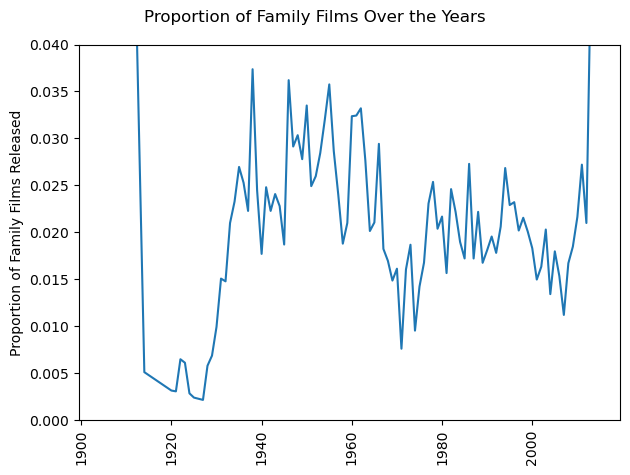

    Start Year  End Year                    War Name  Peak Year
0         1938      1938                 Changkufeng       1938
1         1935      1936        Conquest of Ethiopia       1938
2         1940      1941                 Franco-Thai       1938
3         1939      1939                    Nomonhan       1938
4         1939      1940               Russo-Finnish       1938
5         1937      1941         Third Sino-Japanese       1938
6         1939      1945                World War II       1938
7         1948      1949                Arab-Israeli       1946
8         1947      1991                    Cold War       1946
9         1947      1949               First Kashmir       1946
10        1957      1958                     IfniWar       1955
11        1950      1953                      Korean       1955
12        1954      1955           Off-shore Islands       1955
13        1956      1956                   Sinai War       1955
14        1956      1956  Soviet Invasio

In [585]:
plt.ylim(0, 0.04)
x_val, y_val, df = analyze_genre_wars(df_movies, df_wars, "Family Film")
plt.plot(x_val, y_val)
name_plot(f"Proportion of Family Films Released", f"Proportion of Family Films Over the Years")
print(df)